# CIS6800: Final Project Option 1: fine-tune SAM

### Overview:

Segment Anything Model (SAM) https://segment-anything.com/ was really cool on the surface, but you may hate SAM when you actually do research with it. Imagine you are trying to deploy a robot with SAM, but SAM runs 1 sec per 1 image. SAM use ViT backbone and 1024x1024 image as input, the computation cost is 4^4 = 256 times more intense than 224x224 input. Changing ViT input resolution requires fine-tuning. In this project, you will try to fine-tune a low-resolution SAM.

For data, you will use 10k images from SA-1B dataset https://ai.meta.com/datasets/segment-anything/. There will be a mIoU benchmark score, it will evaluate how your model replicate original SAM output down-scaled. The baseline model will be unfreeze the entire SAM, you will try to use LoRA https://arxiv.org/abs/2106.09685 to improve the score.

You will start with a already implemented SAM model as in official repo https://github.com/facebookresearch/segment-anything/tree/main, you will implement the training, evaluation, and modification such as LoRA.

## SAM Introduction

SAM is an interactive segmentation tool. To help understand SAM, first check our their demo https://segment-anything.com/demo#, official github repo https://github.com/facebookresearch/segment-anything/tree/main, code example https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb,

It is highly encouraged for you to review the SAM paper https://arxiv.org/pdf/2304.02643.pdf. However, the main text is filled with marketing stuff, the Appendix is more about implementation details.

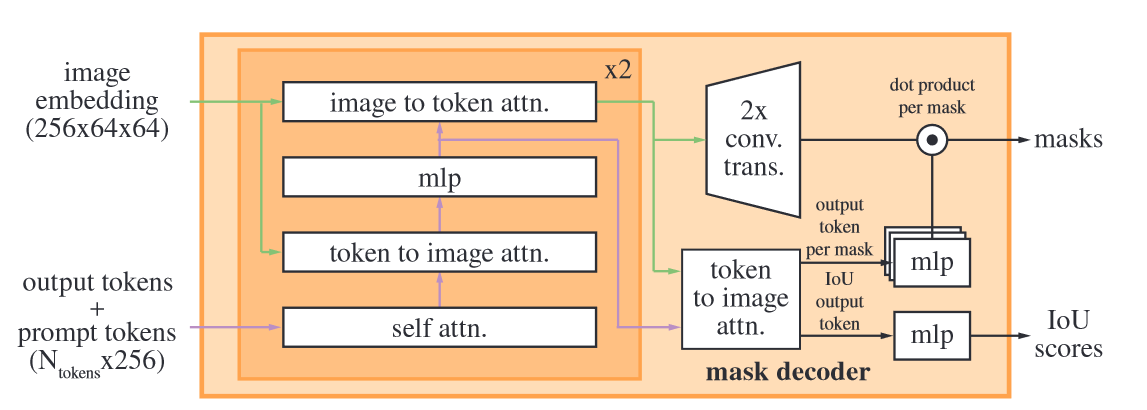

## Data
We provide you with 10k down-sampled images from SA-1B dataset https://ai.meta.com/datasets/segment-anything/



The following code downloads the original dataset, processes it, and visualizes an example.

In [1]:
# manual download: https://drive.google.com/file/d/1cZIex1MTmsUhwpv5aNeKEWMN4pTbAJcm/view?usp=sharing

# !gdown --id 1cZIex1MTmsUhwpv5aNeKEWMN4pTbAJcm
# !unzip -o -q sa1b.zip

/home/rex/.conda/envs/lava-dl/lib/python3.9/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1cZIex1MTmsUhwpv5aNeKEWMN4pTbAJcm
From (redirected): https://drive.google.com/uc?id=1cZIex1MTmsUhwpv5aNeKEWMN4pTbAJcm&confirm=t&uuid=a596b815-ecbe-416c-b471-1b3fe42bbfdd
To: /home/rex/Desktop/github/LoRA-SAM/sa1b.zip
100%|████████████████████████████████████████| 399M/399M [00:15<00:00, 26.3MB/s]


In [2]:
# !pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.9/432.9 kB 15.0 MB/s eta 0:00:00


In [4]:
import glob
import os
import torch
import torchvision
import torchvision.transforms as transforms

from PIL import Image

from pycocotools import mask as mask_utils

import json
import numpy as np
from tqdm import tqdm

input_transforms = transforms.Compose([
    transforms.Resize((160, 256)),
    transforms.ToTensor(),
])

target_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((160, 256)),
])

class SA1B_Dataset(torchvision.datasets.ImageFolder):
    """A data loader for the SA-1B Dataset from "Segment Anything" (SAM)
    This class inherits from :class:`~torchvision.datasets.ImageFolder` so
    the same methods can be overridden to customize the dataset.
    Args:
        root (string): Root directory path.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        loader (callable, optional): A function to load an image given its path.
        is_valid_file (callable, optional): A function that takes path of an Image file
            and check if the file is a valid file (used to check of corrupt files)
     Attributes:
        classes (list): List of the class names sorted alphabetically.
        class_to_idx (dict): Dict with items (class_name, class_index).
        imgs (list): List of (image path, class_index) tuples

    """

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, _ = self.imgs[index] # discard automatic subfolder labels
        image = self.loader(path)
        masks = json.load(open(f'{path[:-3]}json'))['annotations'] # load json masks
        target = []

        for m in masks:
            # decode masks from COCO RLE format
            target.append(mask_utils.decode(m['segmentation']))
        target = np.stack(target, axis=-1)

        if self.transform is not None:
            image = self.transform(image)
        if self.target_transform is not None:
            target = self.target_transform(target)
        target[target > 0] = 1 # convert to binary masks

        return image, target

    def __len__(self):
        return len(self.imgs)


input_reverse_transforms = transforms.Compose([
    transforms.ToPILImage(),
])

import matplotlib.pyplot as plt
def show_image(image, target, row=12, col=12):
    # image: numpy image
    # target: mask [N, H, W]
    fig, axs = plt.subplots(row, col, figsize=(20, 12))
    for i in range(row):
        for j in range(col):
            if i*row+j < target.shape[0]:
                axs[i, j].imshow(image)
                axs[i, j].imshow(target[i*row+j], alpha=0.5)
            else:
                axs[i, j].imshow(image)
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()


In [5]:
path = './sa1b'
dataset = SA1B_Dataset(path, transform=input_transforms, target_transform=target_transforms)
image, target = dataset.__getitem__(3533)
print(image.shape, target.shape)
image = input_reverse_transforms(image)
image = np.array(image)
show_image(image, target, 7, 7)

torch.Size([3, 160, 256]) torch.Size([35, 160, 256])


## SAM model
You will start from offical SAM implementation, the heavy part is already implementated, but you have to make modification to the model, it's critical to read their code and know how things work. You will need to read through SAM's code starting from https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/modeling/image_encoder.py

For SAM: See Appendix A https://arxiv.org/pdf/2304.02643.pdf

In [2]:
# !pip install git+https://github.com/facebookresearch/segment-anything.git
# you may want to make a local copy instead of pip install,
# as you may need to modify their code
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

'wget' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


In [29]:
from segment_anything import sam_model_registry

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
sam.to(device)

# print_params(sam)


c:\Users\REX\Desktop\github\LoRA-SAM\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


## Results (in your report)
1. show the output of original sam model (not fine-tuned) bullied to low-resolution, compare to the original sam at high-resolution (upscale the low-resolution image back to 1600x2560).

Hint: Example code from https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb will always rescale the input to 1024x1024 before passing to sam encoder, you need to modify and bypass SamPredictor's code to pass low-resolution input. In particular, wrong shape of positional encoding will raise error on every attention layer, you will need to either 1) downsample existing PE in every layer or 2) re-initilize PE to the low-resolution shape

2. disccuss the difficulty in applying sam to low resolution input. why fine-tuning is needed, what's the alternative solution.

Hint: start from positional encoding, patchfy operation, first convolution layer, are they scale invariant? why and why not.



Import visualization from predictor_example.ipynb

In [30]:
import matplotlib.pyplot as plt
import cv2

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


Visualization of original SAM at resolution 1024 * 1024

In [31]:
img, target = dataset.__getitem__(3533)
print(img.shape)
target.shape

torch.Size([3, 160, 256])


torch.Size([35, 160, 256])

(1349, 2048)


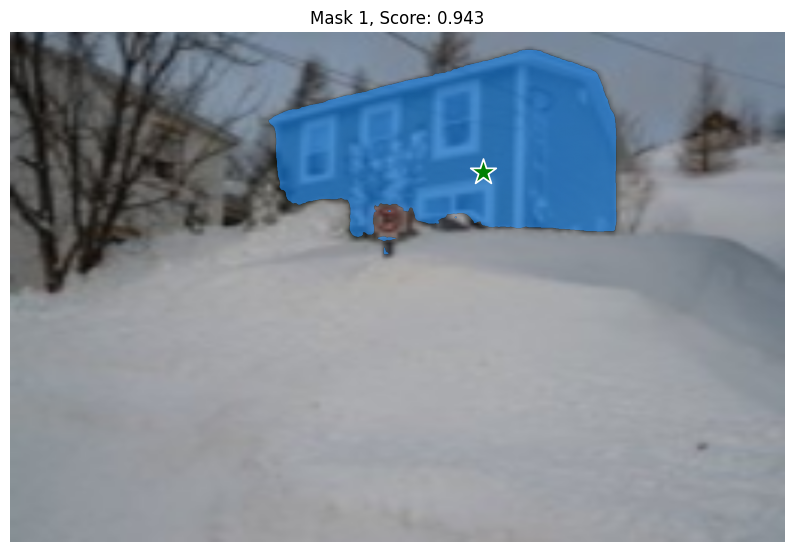

(1349, 2048)


(1349, 2048)


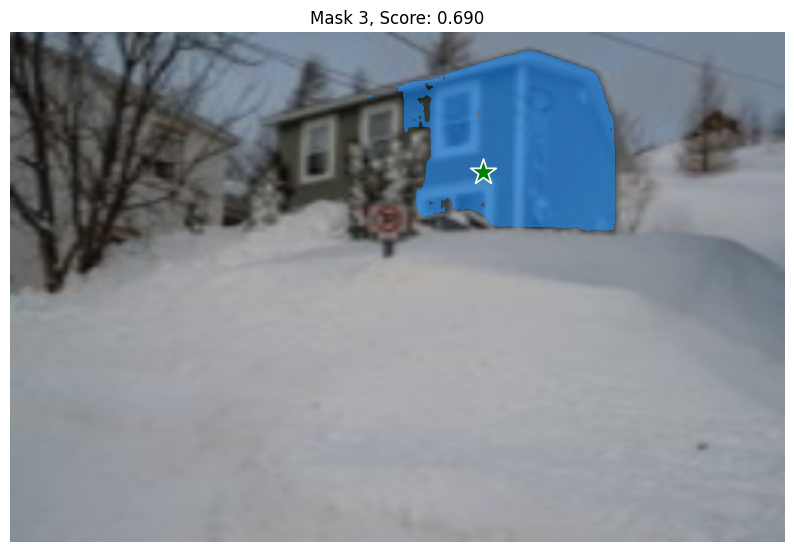

In [35]:
from segment_anything import SamPredictor

# Plot original image
# image = cv2.imread('images/skyline.jpg')


# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = img.permute(1,2,0)
image = cv2.resize(image.numpy(),(2048,1349))

plt.figure(figsize=(10, 10))
plt.title("Original image")
plt.imshow(image)
plt.axis('on')
plt.show()

# Set up predictor
sam_predictor = SamPredictor(sam)
sam_predictor.set_image(image)

input_point = np.array([[1250, 370]])
input_label = np.array([1])
plt.figure(figsize=(10,10))
plt.title("Original image with prompt point")
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

masks, scores, logits = sam_predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    print(mask.shape)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}")
    plt.axis('off')
    plt.show()  


In [55]:
def iou_token_loss(iou_prediction, prediction, targets):
        def calculateIoU(pred, gt):
          intersect = (pred * gt).sum(dim=(-1, -2))
          union = pred.sum(dim=(-1, -2)) + gt.sum(dim=(-1, -2)) - intersect
          ious = intersect.div(union)
          return ious
        pred_mask = prediction#torch.sigmoid(prediction)
        # pred_mask = prediction
        pred_mask[pred_mask > 0.5] = 1
        pred_mask[pred_mask < 0.5] = 0
        
        iou = calculateIoU(pred_mask, targets)
        return iou

(1349, 2048, 35)
(1349, 2048)


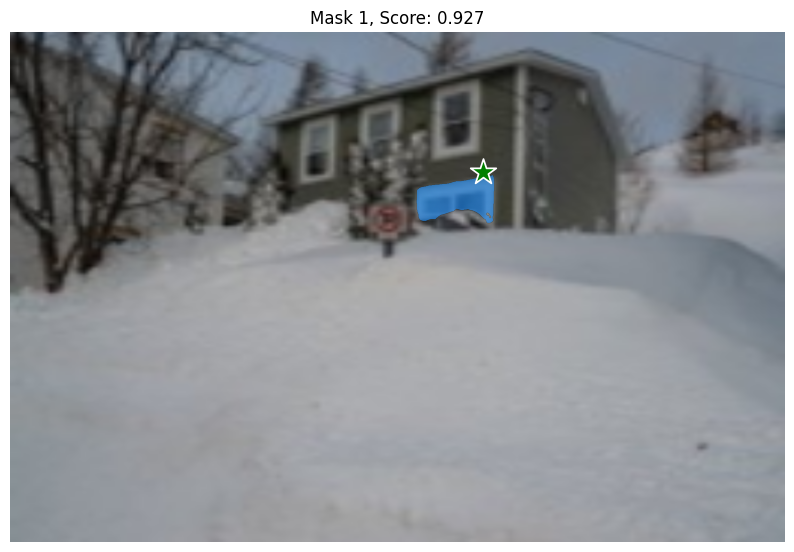

torch.Size([1349, 2048])


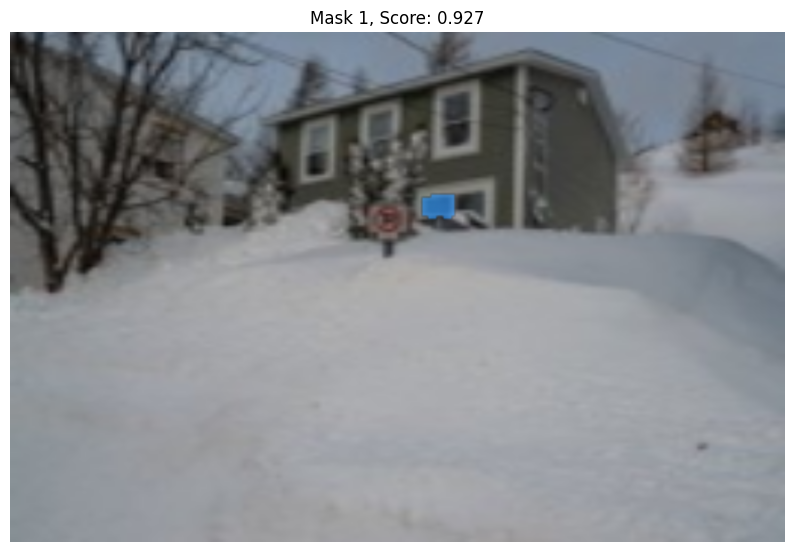

tensor(0.2582)

In [56]:
import random
def get_bbox_from_target(target):
    bbox = []
    for mask in target:
        mask_y, mask_x = torch.where(mask > 0)
        x1, y1, x2, y2 = mask_x.min(), mask_y.min(), mask_x.max(), mask_y.max()
        
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2
        w = (x2 - x1)
        h = (y2 - y1)
        delta_w = min(random.random() * 0.2 * w, 20)
        delta_h = min(random.random() * 0.2 * h, 20)

        x1, y1, x2, y2  = center_x - (w + delta_w) / 2, center_y - (h + delta_h) / 2, \
                            center_x + (w + delta_w) / 2, center_y + (h + delta_h) / 2
        bbox.append(torch.tensor([x1, y1, x2, y2]))

    bbox = torch.stack(bbox, dim=0)
    return bbox
tg = cv2.resize(target.permute(1,2,0).numpy(),(2048,1349))
print(tg.shape)
tg_torch = torch.from_numpy(tg).permute(2,0,1)
bbox = get_bbox_from_target(tg_torch)
masks, scores, logits = sam_predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box= bbox.numpy()[0],
    multimask_output=False,
)

for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    print(mask.shape)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}")
    plt.axis('off')
    plt.show()  

plt.figure(figsize=(10,10))
plt.imshow(image)
print(tg_torch[0].shape)
show_mask(tg_torch[0].numpy(), plt.gca())
plt.title(f"Mask {i+1}, Score: {score:.3f}")
plt.axis('off')
plt.show()  

iou_token_loss(None, torch.from_numpy(mask), tg_torch[0])


Down sample SAM to 256 * 256. No fine tune so far.

total params:  90786352
training params:  90786352


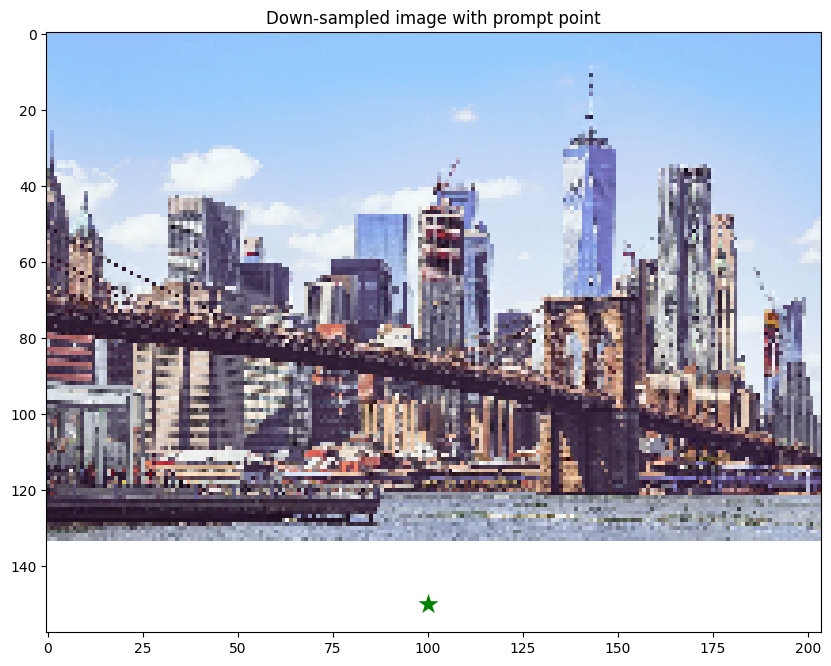

In [21]:
import copy
import torch.nn as nn
import cv2
def downsample(model):
    downsampled_sam = copy.deepcopy(sam)

    _, H, W, _ = sam.image_encoder.pos_embed.shape
    downsampled_sam.image_encoder.pos_embed = nn.Parameter(sam.image_encoder.pos_embed.data[:, :H//4, :W//4, :])
    downsampled_sam.image_encoder.img_size = 256
    downsampled_sam.prompt_encoder.factor = 4
    downsampled_sam.prompt_encoder.image_embedding_size = (16, 16)
    
    return downsampled_sam
    
sam_downsampled = downsample(sam)
print_params(sam_downsampled)

low_res_image = cv2.resize(image, (image.shape[1] // 10, image.shape[0] // 10))
plt.figure(figsize=(10, 10))
plt.title("Down-sampled image")
plt.imshow(low_res_image)
plt.axis('on')
plt.show()

sam_downsampled_predictor = SamPredictor(sam_downsampled)
sam_downsampled_predictor.set_image(low_res_image)

# Input point and label
input_point = np.array([[40, 60]])  # Adjust point for resized image
input_label = np.array([1])
plt.figure(figsize=(10,10))
plt.title("Down-sampled image with prompt point")
plt.imshow(low_res_image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

# Predict on low-res image
masks, scores, logits = sam_downsampled_predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

# Upscale masks back to original resolution
upscaled_masks = [cv2.resize(mask.astype(np.uint8), (image.shape[1], image.shape[0])) for mask in masks]

# Visualize results
for i, (mask, score) in enumerate(zip(upscaled_masks, scores)):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    # plt.imshow(mask, alpha=0.5, cmap='jet')  # Overlay the mask
    plt.title(f"Mask {i+1}, Score: {score:.3f}")
    plt.axis('off')
    plt.show()


Discussion: From the results above, it can be seen that if the original-resolution SAM is directly used to process low-resolution images, the model will no longer be able to segment smaller objects and will instead only detect coarse foreground and background regions. This is not the outcome we desire.

## LoRA module
We also provide you an toy example of LoRA module injected into any nn.Linear class. You will implement similar LoRA class for Conv2D and ConvTranspose2d.

For LoRA: https://arxiv.org/abs/2106.09685

In [8]:
!pip install timm

  Using cached timm-1.0.11-py3-none-any.whl.metadata (48 kB)
  Using cached huggingface_hub-0.26.2-py3-none-any.whl.metadata (13 kB)
  Using cached safetensors-0.4.5-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached urllib3-2.2.3-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2024.8.30-py3-none-any.whl.metadata (2.2 kB)
Using cached timm-1.0.11-py3-none-any.whl (2.3 MB)
Using cached huggingface_hub-0.26.2-py3-none-any.whl (447 kB)
Using cached safetensors-0.4.5-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (436 kB)
Using cached requests-2.32.3-py3-none-any.whl (64 kB)
Using cached certifi-2024.8.30-py3-none-any.whl (167 kB)
Using cached urllib3-2.2.3-py3-none-any.whl (126 kB)


In [1]:
# MLP toy example of LoRA
import torch.nn as nn
from timm.layers.mlp import Mlp
import pytorch_lightning
import numpy as np
mlp = Mlp(768)
print(mlp)

def freeze(module):
    from pytorch_lightning.callbacks.finetuning import BaseFinetuning

    BaseFinetuning.freeze(module, train_bn=True)

freeze(mlp)

/home/rex/.conda/envs/sam/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Mlp(
  (fc1): Linear(in_features=768, out_features=768, bias=True)
  (act): GELU(approximate='none')
  (drop1): Dropout(p=0.0, inplace=False)
  (norm): Identity()
  (fc2): Linear(in_features=768, out_features=768, bias=True)
  (drop2): Dropout(p=0.0, inplace=False)
)


In [6]:
def print_params(model):
  model_parameters = filter(lambda p: True, model.parameters())
  params = sum([np.prod(p.size()) for p in model_parameters])
  print("total params: ", params)
  model_parameters = filter(lambda p: p.requires_grad, model.parameters())
  params = sum([np.prod(p.size()) for p in model_parameters])
  print("training params: ", params)

In [3]:
print_params(mlp)

total params:  1181184
training params:  0


In [4]:
# inject LoRA
from loralib.lora import LoRA_injection

LoRA_injection(mlp,['linear','conv'])


In [5]:
print(mlp)

Mlp(
  (fc1): LoRAedLinear(
    (dense): Linear(in_features=768, out_features=768, bias=True)
    (lora_dropout): Dropout(p=1, inplace=False)
  )
  (act): GELU(approximate='none')
  (drop1): Dropout(p=0.0, inplace=False)
  (norm): Identity()
  (fc2): LoRAedLinear(
    (dense): Linear(in_features=768, out_features=768, bias=True)
    (lora_dropout): Dropout(p=1, inplace=False)
  )
  (drop2): Dropout(p=0.0, inplace=False)
)


In [9]:
print(mlp.fc1.dense.weight.requires_grad) # load this from trained model, freeze
print(mlp.fc1.lora_A.requires_grad) # LoRA initilized, do not freeze

False
True


In [10]:
print_params(mlp)

total params:  1193472
training params:  12288


## Methods and Results (in your report)

1. how do you implement LoRA, which part of SAM model do you fine-tune?
2. summarize number of parameters before and after LoRA
3. compare training results of completely unfreeze SAM v.s. LoRA.

## SAM target assignment

Take a closer look at the data, there's some big mask containing small masks. the SAM model will predict 3 output masks (with 3 confidence score) for a single prompt, 3 mask outputs is ordered from big to small objects. You will need to implement function to sample these 3 masks from masks of one image in SA-1B dataset.

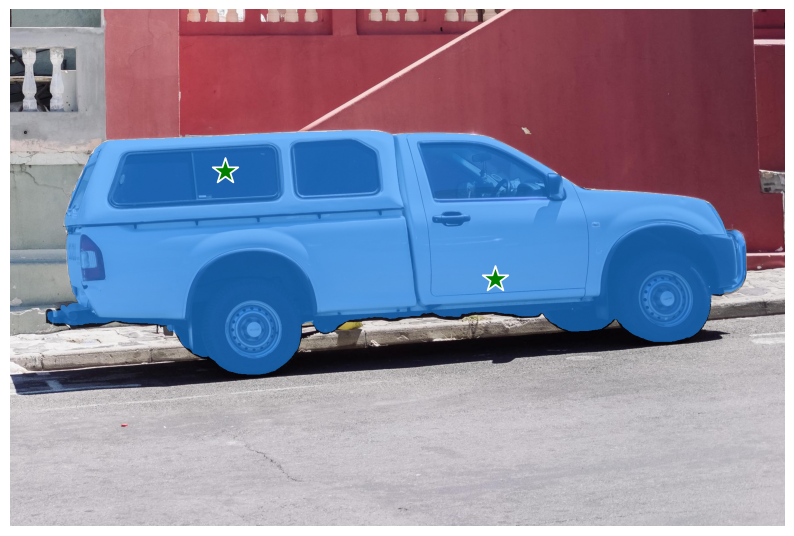

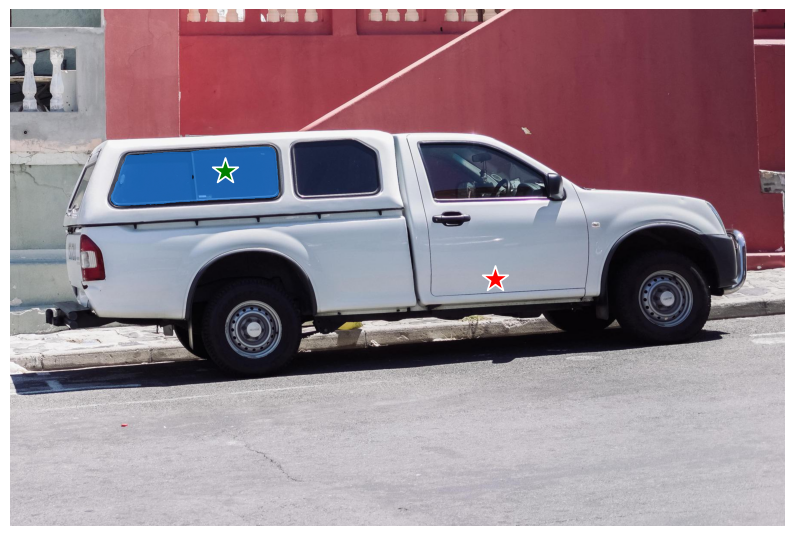

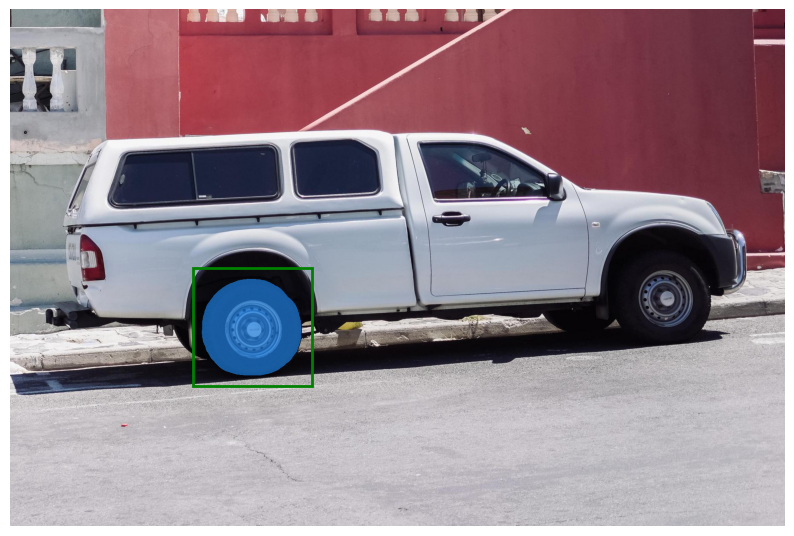

In [29]:
def point_sample(all_masks, points_coords, points_label):
    # all_masks: [N, H, W], one image, N masks
    # points_coords: (N, 2)
    # points_label: (N, 1), 1 for foreground, 0 for background
    # return: sampled_masks: [3, H, W], masks order from big to small
    # you can modify the signature of this function
    N, H, W = all_masks.shape
    mask_size = torch.count_nonzero(all_masks,dim=(2,3))
    index = torch.argsort(mask_size,descending=True)
    sampled_mask = all_masks[index]
    sampled_point = points_coords[index]
    sampled_label = points_label[index]
    return sampled_mask[:3], sampled_point[:3], sampled_label[:3]


def box_sample(all_masks, bbox):
    # all_masks: [N, H, W], one image, N masks
    # bbox: (xxyy)
    # return: sampled_masks: [3, H, W], masks order from big to small
    # you can modify the signature of this function
    ...

# you don't need to implement the case with both points and box

## Visulize (in your report)

show the returned 3 masks, ordered from big to small

show `point_sample()` with 1. one positive point, 2. one positive and one negative point. 3. multiple points with both positive and negative

show `box_sample()` with 1. one positive box

## Training
as described in SAM paper Section 3 and Appendix A. You simulate an interactive segmentation setup during training: you need to implement 1a. single point prompt training 1b. iterative training up to 3 iteration 2. box prompt training, only 1 iteration;

### 1a and 2: one iteration training
First, with equal probability either a foreground point
or bounding box is selected randomly for the target mask.
Points are sampled uniformly from the ground truth mask.
Boxes are taken as the ground truth mask’s bounding box,
with random noise added in each coordinate with standard
deviation equal to 10% of the box sidelength, to a maximum of 20 pixels.

### 1b: three iteration training
After making a prediction from this first prompt, subsequent points are selected uniformly from the error region
between the previous mask prediction and the ground truth
mask. Each new point is foreground or background if the error region is a false negative or false positive, respectively.
We also supply the mask prediction from the previous iteration as an additional prompt to our model. To provide
the next iteration with maximal information, we supply the
unthresholded mask logits instead of the binarized mask.
When multiple masks are returned, the mask passed to the
next iteration and used to sample the next point is the one
with the highest predicted IoU.

- You do not need to implement text prompt as there's no text data in SA-1B dataset

In [ ]:
from segment_anything.modeling.sam import Sam
import pytorch_lightning as pl
import random
import pdb
from loralib.lora import LoRA_injection


class MyFastSAM(pl.LightningModule):
    def __init__(self, orig_sam: Sam, lora_rank: int, lora_scale: float):
        super().__init__()
        self.lora_sam = orig_sam
        LoRA_injection(self.lora_sam,['linear','conv','convT'], lora_rank, lora_scale)
        

    def forward(self, *args, **kwargs):
        """
        comments imported from original SAM code

        Arguments:
          batched_input (list(dict)): A list over input images, each a
            dictionary with the following keys. A prompt key can be
            excluded if it is not present.
              'image': The image as a torch tensor in 3xHxW format,
                already transformed for input to the model.
              'original_size': (tuple(int, int)) The original size of
                the image before transformation, as (H, W).
              'point_coords': (torch.Tensor) Batched point prompts for
                this image, with shape BxNx2. Already transformed to the
                input frame of the model.
              'point_labels': (torch.Tensor) Batched labels for point prompts,
                with shape BxN.
              'boxes': (torch.Tensor) Batched box inputs, with shape Bx4.
                Already transformed to the input frame of the model.
              'mask_inputs': (torch.Tensor) Batched mask inputs to the model,
                in the form Bx1xHxW.
          multimask_output (bool): Whether the model should predict multiple
            disambiguating masks, or return a single mask.

        Returns:
          (list(dict)): A list over input images, where each element is
            as dictionary with the following keys.
              'masks': (torch.Tensor) Batched binary mask predictions,
                with shape BxCxHxW, where B is the number of input prompts,
                C is determined by multimask_output, and (H, W) is the
                original size of the image.
              'iou_predictions': (torch.Tensor) The model's predictions
                of mask quality, in shape BxC.
              'low_res_logits': (torch.Tensor) Low resolution logits with
                shape BxCxHxW, where H=W=256. Can be passed as mask input
                to subsequent iterations of prediction.
        """
        return self.lora_sam(*args, **kwargs)

    def configure_optimizers(self):
        lora_parameters = [param for param in self.parameters() if param.requires_grad]
        # make sure original sam don't requires_grad
        optimizer = torch.optim.AdamW(lora_parameters, lr=1e-5)
        return optimizer

    @staticmethod
    def mask_dice_loss(prediction, targets):
        h, w = targets.shape[-2:]
        targets = targets.reshape(-1, h, w)

        pred_mask = torch.sigmoid(prediction[:, -1, :, :])
        dice_loss = 2 * torch.sum( pred_mask * targets, dim=(-1, -2) ) / \
        ( torch.sum( pred_mask ** 2, dim=(-1, -2) ) + torch.sum( targets ** 2, dim=(-1, -2) ) + 1e-5)
        dice_loss = (1 - dice_loss)
        dice_loss = torch.mean(dice_loss)
        return dice_loss

    @staticmethod
    def mask_focal_loss(prediction, targets, alpha, gamma):
        h, w = targets.shape[-2:]
        targets = targets.reshape(-1, h, w)

        pred_mask = torch.sigmoid(prediction[:, -1, :, :])
        fl_1 = -alpha * ( (1 - pred_mask[prediction > .5]) ** gamma ) * \
            torch.log(pred_mask[prediction > .5] + 1e-6)
        
        fl_2 = -(1-alpha) * ( (pred_mask[prediction < .5]) ** gamma ) * \
            torch.log(1 - pred_mask[prediction < .5] + 1e-6)
        
        return (torch.mean(fl_1) + torch.mean(fl_2))

    @staticmethod
    def iou_token_loss(iou_prediction, prediction, targets):
        def calculateIoU(pred, gt):
          intersect = (pred * gt).sum(dim=(-1, -2))
          union = pred.sum(dim=(-1, -2)) + gt.sum(dim=(-1, -2)) - intersect
          ious = intersect.div(union)
          return ious
        pred_mask = torch.sigmoid(prediction)
        # pred_mask = prediction
        pred_mask[pred_mask > 0.5] = 1
        pred_mask[pred_mask < 0.5] = 0
        
        iou = calculateIoU(pred_mask, targets)
        return iou

    def training_step(self, batch):
        batched_input = self.construct_batched_input(batch)
        device = self.device
        # 1a. single point prompt training
        # 1b. iterative point prompt training up to 3 iteration
        # 2. box prompt training, only 1 iteration
        predictions = self.lora_sam.batch_forward_box(
            input_images = batched_input['image'].to(device),
            boxes = batched_input['bbox'].to(device),
            original_size=(160, 256),
            multimask_output=False,
        ) 

        pdb.set_trace()
        target = batched_input['target']
        loss = ...
        self.log('train_loss', loss, prog_bar=True)
        # During training, we backprop only the minimum loss over the 3 output masks.
        # sam paper main text Section 3
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        ...
        loss = ...
        # use same procedure as training, monitor the loss
        self.log('val_loss', loss, prog_bar=True)

    def construct_batched_input(self, batch):
        image, target = batch # lists
        device = self.device

        def load_num_masks(target, NUM_MASK_PER_IMG):
            num_masks = target.shape[0]
            selected = []
            if num_masks >= NUM_MASK_PER_IMG :
                all_mask_index = np.arange(num_masks)
                np.random.shuffle(all_mask_index)
                select_mask_indices = all_mask_index[:NUM_MASK_PER_IMG]
            else:
                select_mask_indices = np.arange(num_masks)
                for _ in range(NUM_MASK_PER_IMG-num_masks):
                  select_mask_indices = np.append(select_mask_indices, select_mask_indices[-1])

            # Select only 
            for ind in select_mask_indices:
                m = target[ind]
                # decode masks from COCO RLE format
                selected.append(m)

            target = torch.stack(selected, dim=0)
            return target

        def get_bbox_from_target(target):
            bbox = []
            for mask in target:
                mask_y, mask_x = torch.where(mask > 0)
                x1, y1, x2, y2 = mask_x.min(), mask_y.min(), mask_x.max(), mask_y.max()
                
                center_x = (x1 + x2) / 2
                center_y = (y1 + y2) / 2
                w = (x2 - x1)
                h = (y2 - y1)
                delta_w = min(random.random() * 0.2 * w, 20)
                delta_h = min(random.random() * 0.2 * h, 20)

                x1, y1, x2, y2  = center_x - (w + delta_w) / 2, center_y - (h + delta_h) / 2, \
                                    center_x + (w + delta_w) / 2, center_y + (h + delta_h) / 2
                bbox.append(torch.tensor([x1, y1, x2, y2]))

            bbox = torch.stack(bbox, dim=0)
            return bbox
        
        image = torch.stack(image,dim=0)

        new_target = [load_num_masks(tg,16) for tg in target]
        new_target = torch.stack(new_target,dim=0)
        
        bbox = [get_bbox_from_target(tg) for tg in new_target]
        bbox = torch.stack(bbox,dim=0)
        
        batch_input = {
            'image':image,
            'original_size':(160, 256),
            'bbox':bbox,
            'target': new_target
        }

        return batch_input
        

In [6]:
from segment_anything import sam_model_registry
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
sam.to(device)
import copy
import torch.nn as nn
def downsample(model):
    downsampled_sam = copy.deepcopy(sam)

    _, H, W, _ = sam.image_encoder.pos_embed.shape
    downsampled_sam.image_encoder.pos_embed = nn.Parameter(sam.image_encoder.pos_embed.data[:, :H//4, :W//4, :])
    downsampled_sam.image_encoder.img_size = 256
    downsampled_sam.prompt_encoder.factor = 4
    downsampled_sam.prompt_encoder.image_embedding_size = (16, 16)
    
    return downsampled_sam
    
sam_downsampled = downsample(sam)

def collate_fn(batches):
    batch_data = []
    targets = []

    for b in batches:
        image, target = b
        batch_data.append(image)

        targets.append(target)

    return batch_data, targets

/home/rex/Desktop/github/LoRA-SAM/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [7]:
from tensorboardX import SummaryWriter
import argparse
import time
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import torch
import pdb

parser = argparse.ArgumentParser()
parser.add_argument('--gpu_id', type=str, default='0')
parser.add_argument('--data_dir', type=str, default='/home/rex/Desktop/github/EventMonoPose/baseline/Eventhpe/data')
parser.add_argument('--result_dir', type=str, default='./exp')
parser.add_argument('--save_dir', type=str, default='./model')
parser.add_argument('--log_dir', type=str, default='optimize')
parser.add_argument('--train', type=bool, default=True)
parser.add_argument('--lr', type=float, default=0.001)
parser.add_argument('--epoch', type=int, default=50)
args = parser.parse_args("")

os.makedirs(args.save_dir, exist_ok=True)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:%s" % args.gpu_id if use_cuda else "cpu")
dtype = torch.float32

start_time = time.strftime("%Y-%m-%d-%H-%M", time.localtime())
writer = SummaryWriter('%s/%s/%s' % (args.result_dir, args.log_dir, start_time))
print('[tensorboard] %s/%s/%s' % (args.result_dir, args.log_dir, start_time))
save_dir = '%s/%s/%s' % (args.result_dir, args.log_dir, start_time)

path = './sa1b'
SA1Bdataset = SA1B_Dataset(path, transform=input_transforms, target_transform=target_transforms)
train_loader = DataLoader(SA1Bdataset,batch_size=16,shuffle=True,collate_fn=collate_fn)

model = MyFastSAM(sam_downsampled, 4, 1.0).to(device)

if args.train:

    pbar = tqdm(range(args.epoch))
    total_step = len(train_loader)
    for i in pbar:
        for iter, data in enumerate(train_loader):
            print(iter)
            heatmap,loss,lr = model.training_step(data)


            if iter%100==0:
            #     pred = viz(heatmap.cpu(),batch['data'].cpu().numpy())
            #     gt = viz(batch['label'].cpu(),batch['data'].cpu().numpy())

                writer.add_scalar('train_loss',loss,global_step=i*total_step+iter)
            #     writer.add_images('train/pred', pred, epoch*total_step+iter, dataformats='HWC')
            #     writer.add_images('train/gt', gt, epoch*total_step+iter, dataformats='HWC')

        torch.save({
                'model_state_dict': model.state_dict(),
            }, '%s/model.pkl' % save_dir)

[tensorboard] ./exp/optimize/2024-11-25-12-00


  0%|          | 0/50 [00:00<?, ?it/s]

0


  0%|          | 0/50 [00:47<?, ?it/s]

torch.Size([16, 16, 512])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 256 but got size 512 for tensor number 1 in the list.

## Results (in your report)

1. show the process of sampling points in multiple iteration training, how the GT mask is assigned in each iteration
1. show training / validation loss curve, for each loss and sum of all losses.
1. besides loss, think about metrics such as mIoU, mAP, how to implement them in the sam's setting, or why not to implement each metrics, what make them unsuitable for sam's task? Remember: 1) we only have masks without category 2) sam need prompts.
1. on your trained model, cherry pick good examples, but also pick bad examples, rescale the input image back to 1024x1024 pixels, pass them to the original SAM model with the original pipeline, compare to your low-resolution LoRA results, disccuss what make them good or bad.